<a href="https://colab.research.google.com/github/omidmno2/stockMarketPrediction_DL/blob/main/Ghadir_test_CNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [230]:
!wget --no-check-certificate \
    https://github.com/omidmno2/stockMarketPrediction_DL/raw/main/tse_en.csv \
    -o /tmp/tse_en.csv

In [231]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

In [232]:
df = pd.read_csv("tse_en.csv")
df[df.Symbol == "وغدير"]

,Date,Symbol,Name,Yesterday,Open,Last,Close,Close Changes,Low,High,Number Traded,Volume,Value Traded
4447,2009-02-01,وغدير,سرمايه‌گذاري‌غدير(هلدينگ‌,1888,1640,1720,1708,-180,1640.0,1775.0,1069,20335924,34724345237
4569,2009-02-02,وغدير,سرمايه‌گذاري‌غدير(هلدينگ‌,1708,1750,1657,1670,-38,1657.0,1750.0,67,1835207,3042332902
4708,2009-02-03,وغدير,سرمايه‌گذاري‌غدير(هلدينگ‌,1670,1620,1620,1620,-50,1620.0,1620.0,104,2524795,4090167900
4840,2009-02-04,وغدير,سرمايه‌گذاري‌غدير(هلدينگ‌,1620,1572,1572,1572,-48,1572.0,1572.0,87,2527581,3973357332
4968,2009-02-07,وغدير,سرمايه‌گذاري‌غدير(هلدينگ‌,1572,1525,1610,1530,-42,1525.0,1619.0,242,4698245,7186955357
...,...,...,...,...,...,...,...,...,...,...,...,...,...
817362,2021-06-22,وغدير,سرمايه‌گذاري‌غدير(هلدينگ‌,10820,10900,11080,10940,120,10700.0,11130.0,2964,21593318,236133450920
817675,2021-06-23,وغدير,سرمايه‌گذاري‌غدير(هلدينگ‌,10940,10900,11480,11400,460,10900.0,11480.0,3995,74474963,848982027130
818116,2021-06-26,وغدير,سرمايه‌گذاري‌غدير(هلدينگ‌,11400,11780,11670,11850,450,11480.0,11970.0,6118,60215914,713830827180
818687,2021-06-27,وغدير,سرمايه‌گذاري‌غدير(هلدينگ‌,11850,11410,11700,11800,-50,11410.0,12090.0,4093,27942565,329721388620


In [233]:
ghadir = df[df.Symbol == "وغدير"]
ghadir.index = pd.to_datetime(ghadir['Date'])
ghadir = ghadir.drop(columns=['Symbol', 'Name', 'Date']).dropna()
ghadir = ghadir.head(2400)

In [234]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

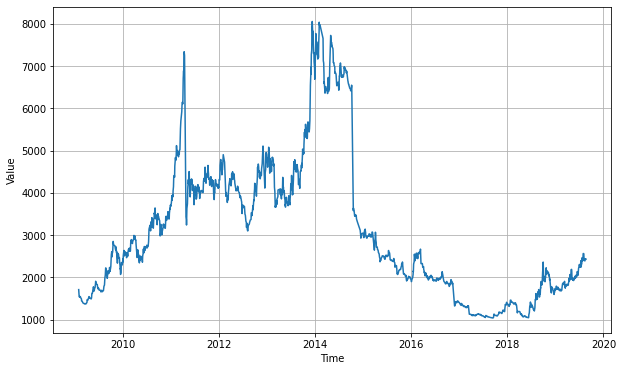

In [235]:
# Normal data

series = np.array(ghadir.Close)
time = np.array(ghadir.index)
plt.figure(figsize=(10, 6))
plot_series(time, series)

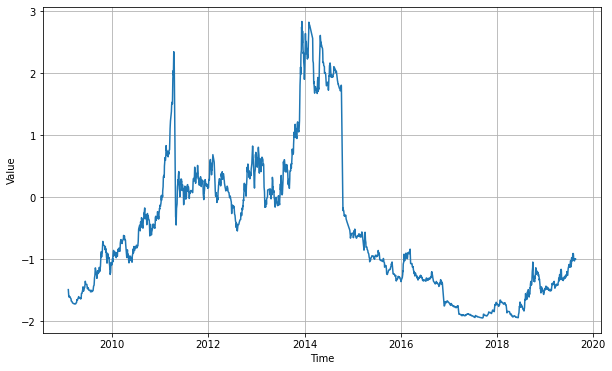

In [236]:
# Standardized Data

series = ghadir['Close'].values.reshape(-1, 1)
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

series = np.array(series)
time = np.array(ghadir.index)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [237]:
split_time = 2000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [238]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [239]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2000,)
Epoch 1/100
8/8 [==============================] - 5s 42ms/step - loss: 3.4940 - mae: 3.9417
Epoch 2/100
8/8 [==============================] - 1s 51ms/step - loss: 3.4131 - mae: 3.8616
Epoch 3/100
8/8 [==============================] - 1s 50ms/step - loss: 3.2852 - mae: 3.7350
Epoch 4/100
8/8 [==============================] - 1s 53ms/step - loss: 3.1304 - mae: 3.5821
Epoch 5/100
8/8 [==============================] - 1s 51ms/step - loss: 2.9544 - mae: 3.4085
Epoch 6/100
8/8 [==============================] - 1s 50ms/step - loss: 2.7647 - mae: 3.2216
Epoch 7/100
8/8 [==============================] - 1s 52ms/step - loss: 2.5587 - mae: 3.0184
Epoch 8/100
8/8 [==============================] - 1s 51ms/step - loss: 2.3408 - mae: 2.8027
Epoch 9/100
8/8 [==============================] - 1s 50ms/step - loss: 2.1128 - mae: 2.5756
Epoch 10/100
8/8 [==============================] - 1s 50ms/s

(1e-08, 0.0001, 0.0, 2.0)

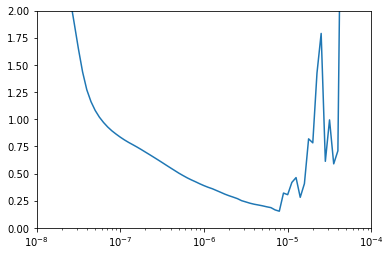

In [243]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 2])

In [244]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=8e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
20/20 [==============================] - 4s 36ms/step - loss: 0.8156 - mae: 1.2040
Epoch 2/150
20/20 [==============================] - 1s 35ms/step - loss: 0.2290 - mae: 0.5482
Epoch 3/150
20/20 [==============================] - 1s 35ms/step - loss: 0.1209 - mae: 0.3620
Epoch 4/150
20/20 [==============================] - 1s 36ms/step - loss: 0.0816 - mae: 0.2797
Epoch 5/150
20/20 [==============================] - 1s 36ms/step - loss: 0.0740 - mae: 0.2616
Epoch 6/150
20/20 [==============================] - 1s 36ms/step - loss: 0.0716 - mae: 0.2597
Epoch 7/150
20/20 [==============================] - 1s 35ms/step - loss: 0.0656 - mae: 0.2444
Epoch 8/150
20/20 [==============================] - 1s 37ms/step - loss: 0.0619 - mae: 0.2313
Epoch 9/150
20/20 [==============================] - 1s 36ms/step - loss: 0.0591 - mae: 0.2239
Epoch 10/150
20/20 [==============================] - 1s 35ms/step - loss: 0.0571 - mae: 0.2171
Epoch 11/150
20/20 [=============================

In [245]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

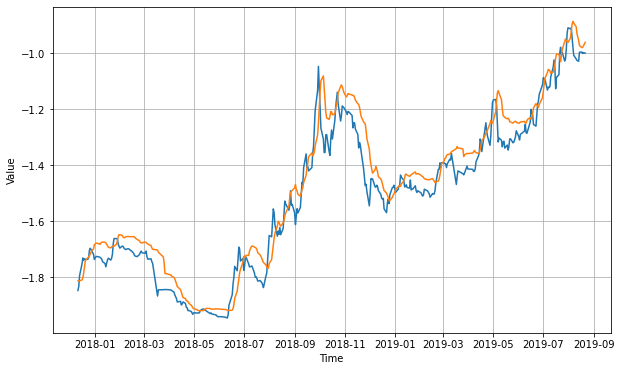

In [246]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [221]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

3.2280734

In [ ]:
print(rnn_forecast)

# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS